In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import os

In [2]:
from sklearn.model_selection import train_test_split #in order to split the data set
from sklearn import preprocessing #scaling, transforming, and wrangling data.

from sklearn import svm
#these two are need to perform cross-validation
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import GridSearchCV

#metrics to model the performance
from sklearn.metrics import mean_squared_error, r2_score

#in order to save the model for future use
from sklearn.externals import joblib 

from sklearn.decomposition import PCA

In [18]:
df = pd.read_pickle("estate_no_ttf.pkl")
df = df.loc[:, (df != df.iloc[0]).any()]

# HOMO Learn

In [19]:
df.keys()

Index(['name', 'smiles', 'HOMO', 'E_opt', 'ssssB', 'sCH3', 'tCH', 'dsCH',
       'aaCH', 'tsC', 'dssC', 'aasC', 'aaaC', 'ssssC', 'sNH2', 'ssNH', 'tN',
       'dsN', 'aaN', 'sssN', 'ddsN', 'aasN', 'sOH', 'dO', 'ssO', 'sF', 'aaS',
       'ddssS'],
      dtype='object')

In [20]:
y = df.HOMO
X = df

for key in [ 'name', 'smiles', 'HOMO', 'E_opt',]:
    X = X.drop(key,axis=1)
    
X.keys()

Index(['ssssB', 'sCH3', 'tCH', 'dsCH', 'aaCH', 'tsC', 'dssC', 'aasC', 'aaaC',
       'ssssC', 'sNH2', 'ssNH', 'tN', 'dsN', 'aaN', 'sssN', 'ddsN', 'aasN',
       'sOH', 'dO', 'ssO', 'sF', 'aaS', 'ddssS'],
      dtype='object')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                   random_state = 90)

In [22]:
clf= joblib.load("estate_nottf_homo_90.pkl")

In [23]:
clf.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=8, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.005,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [24]:
#Evaluate model pipeline on test data
pred = clf.predict(X_test)

print("R2 score: ", r2_score(y_test, pred)) #best possible score is 1
print("MSE: ", mean_squared_error(y_test, pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, pred)))

R2 score:  0.9243879047757217
MSE:  0.0026923280688392515
RMSE 0.05188764851907679


In [25]:
homo = df.HOMO
df_error = pd.DataFrame(columns=["name","idx"])

error_homo = y_test.values - pred

for i,er in enumerate(error_homo):
    if np.abs(er) > homo.std():
        idx = y_test.index[i]
        name = df.loc[idx]["name"]
        print(name,idx)
        data = {"name":name,"idx":idx}
        df_error = df_error.append(data,ignore_index=True)

In [26]:
df_error.head()

,name,idx


In [28]:
sns.set()

[-7.97161524, -6.695380640000001, -7.97161524, -6.695380640000001]

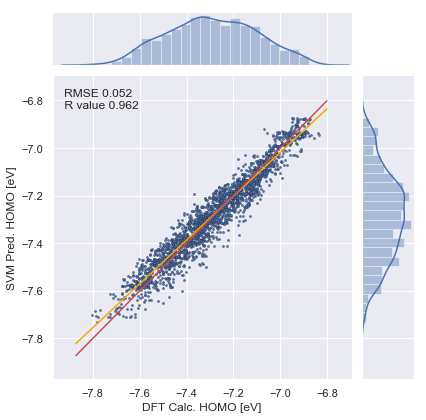

In [29]:
data = pd.DataFrame(columns=["DFT Calc. HOMO [eV]","SVM Pred. HOMO [eV]"])
data["DFT Calc. HOMO [eV]"] = y_test.values
data["SVM Pred. HOMO [eV]"] = pred



ax = sns.jointplot("DFT Calc. HOMO [eV]","SVM Pred. HOMO [eV]",data, kind='scatter',s=5,edgecolor="black",linewidth=0.2,marginal_kws=dict(kde=True))

slope,intercept,r_value,p_value,std_error = scipy.stats.linregress(y_test,pred)
ax.ax_joint.text(df.HOMO.min()+.1,df.HOMO.max(),"RMSE {:.3f} \n R value {:.3f}".format(np.sqrt(mean_squared_error(y_test, pred)),r_value),horizontalalignment='center',
     verticalalignment='center')

x = np.arange(df.HOMO.min(),df.HOMO.max(),0.01)
ax.ax_joint.plot(x,intercept+slope*x,color="orange")
ax.ax_joint.plot(x,x,'r-')

error = y_test.values - pred
for i,er in enumerate(error):
    if np.abs(er) > homo.std():
        #ax.ax_joint.text(y_test.values[i],pred[i],y_test.index[i])
        ax.ax_joint.plot(y_test.values[i],pred[i],'ro',markersize=3)
        print(y_test.index[i])

ax.ax_joint.axis([df.HOMO.min()-0.1, df.HOMO.max()+0.1,df.HOMO.min()-0.1, df.HOMO.max()+0.1])
#ax.savefig("/home/freja/phd/latex/phd_thesis/classicthesis/fig/svm_estate_sns.pdf")

# LUMO Learn

In [37]:
new_lumo = df.HOMO + df.E_opt
y = new_lumo
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                   random_state = 90)


In [31]:
len(X_test.keys())

24

In [34]:
clf = joblib.load("estate_nottf_lumo_90.pkl")
pred = clf.predict(X_test)
print("R2 score: ", r2_score(y_test, pred)) #best possible score is 1
print("MSE: ", mean_squared_error(y_test, pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, pred)))

R2 score:  0.9041640731784516
MSE:  0.002785693476395855
RMSE 0.05277966915769608


In [42]:
error_lumo = y_test.values - pred
for i,er in enumerate(error):
    if np.abs(er) > homo.std():
        idx = y_test.index[i]
        name = df.loc[idx]["name"]
        #print(name,idx)
        data = {"name":name,"idx":int(idx)}
        #print(data)
        df_error = df_error.append(data,ignore_index=True)
df_error

,name,idx
0,572 2-0-30-40-41 572 2-11-29-39-19 572 ...,572
1,1402 2-11-15-14-39 1402 2-14-15-15-17 14...,1402
2,163 2-0-14-22-17 163 2-11-18-17-14 163 ...,163
3,572 2-0-30-40-41 572 2-11-29-39-19 572 ...,572
4,1402 2-11-15-14-39 1402 2-14-15-15-17 14...,1402
5,163 2-0-14-22-17 163 2-11-18-17-14 163 ...,163
6,572 2-0-30-40-41 572 2-11-29-39-19 572 ...,572
7,1402 2-11-15-14-39 1402 2-14-15-15-17 14...,1402
8,163 2-0-14-22-17 163 2-11-18-17-14 163 ...,163


/home/freja/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


572
1402
163


[-5.674036159999999, -4.44768208, -5.674036159999999, -4.44768208]

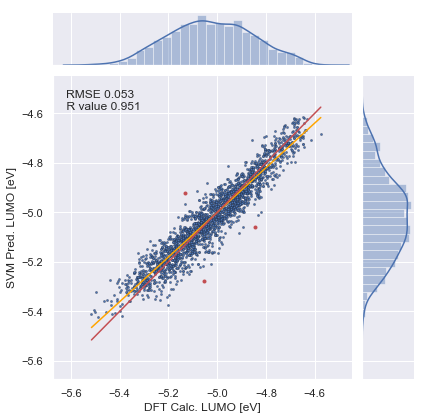

In [38]:
data = pd.DataFrame(columns=["DFT Calc. LUMO [eV]","SVM Pred. LUMO [eV]"])
data["DFT Calc. LUMO [eV]"] = y_test.values
data["SVM Pred. LUMO [eV]"] = pred

ax = sns.jointplot("DFT Calc. LUMO [eV]","SVM Pred. LUMO [eV]",data, kind='scatter',s=5,edgecolor="black",linewidth=0.2,marginal_kws=dict(kde=True))

slope,intercept,r_value,p_value,std_error = scipy.stats.linregress(y_test,pred)
ax.ax_joint.text(new_lumo.min()+.1,new_lumo.max(),"RMSE {:.3f} \n R value {:.3f}".format(np.sqrt(mean_squared_error(y_test, pred)),r_value),horizontalalignment='center',
     verticalalignment='center')



x = np.arange(y_test.values.min(),y_test.values.max(),0.01)
ax.ax_joint.plot(x,intercept+slope*x,color="orange")
ax.ax_joint.plot(x,x,'r-')

error = y_test.values - pred
plotted = True
for i,er in enumerate(error):
    if np.abs(er) > homo.std():
        #ax.ax_joint.text(y_test.values[i],pred[i],y_test.index[i])
        ax.ax_joint.plot(y_test.values[i],pred[i],'ro',markersize=3)
        print(y_test.index[i])

ax.ax_joint.axis([new_lumo.min()-0.1, new_lumo.max()+0.1,new_lumo.min()-0.1, new_lumo.max()+0.1])
#ax.savefig("/home/freja/phd/latex/phd_thesis/classicthesis/fig/svm_estate_sns_lumo.pdf")